In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
import torch.optim as optim
from torch.utils.data import Dataset,DataLoader,Subset
from torchvision import transforms as tf
import numpy as np
import matplotlib.pyplot as plt
from itertools import pairwise
import math
from typing import Optional, Union, Tuple
from accelerate import Accelerator
import pickle
import os
from einops import rearrange, repeat
import cv2
#from torch_ema import ExponentialMovingAverage as EMA
import torch.nn.functional as F
from torch_ema import ExponentialMovingAverage as EMA
from types import SimpleNamespace
from tqdm import tqdm
import torch.optim.lr_scheduler as lr_scheduler
import wandb

In [2]:
# Check the total memory available on the GPU
total_memory = torch.cuda.get_device_properties(0).total_memory / 1024**3  # Convert to GB

# Check the memory allocated by PyTorch
allocated_memory = torch.cuda.memory_allocated(0) / 1024**3  # Convert to GB

# Check the memory cached by PyTorch
cached_memory = torch.cuda.memory_reserved(0) / 1024**3  # Convert to GB

print(f"Total Memory: {total_memory:.2f} GB")
print(f"Allocated Memory: {allocated_memory:.2f} GB")
print(f"Cached Memory: {cached_memory:.2f} GB")

Total Memory: 23.70 GB
Allocated Memory: 0.00 GB
Cached Memory: 0.00 GB


In [3]:
rawdatapath = 'PRJ_AUTO_NOISEPARAM/data/raw/ANMO/*'
procsavepath = 'PRJ_AUTO_NOISEPARAM/data/processed/ANMO'
procsavepathfile = os.path.join(procsavepath, 'anmo_noise_data_normalized.pkl')

if os.path.isfile(procsavepathfile) == 1:
    with open(procsavepathfile, 'rb') as f:
        trainset = pickle.load(f)
else:
    print("no data loaded")

In [4]:
trainsubset = Subset(trainset, range(len(trainset)))

In [5]:
##Generating the dataset
class Swissroll(Dataset):
    def __init__(self, tmin, tmax, N):
        t = tmin + torch.linspace(0, 1, N) * tmax
        self.vals = torch.stack([t*torch.cos(t)/tmax, t*torch.sin(t)/tmax]).T

    def __len__(self):
        return len(self.vals)

    def __getitem__(self, i):
        return self.vals[i]
    

 ##Deciding how noise will be sampled    

class Schedule:
    '''Diffusion noise schedules parameterized by sigma'''
    def __init__(self, sigmas: torch.FloatTensor):
        self.sigmas = sigmas

    def __getitem__(self, i) -> torch.FloatTensor:
        return self.sigmas[i]

    def __len__(self) -> int:
        return len(self.sigmas)

    def sample_sigmas(self, steps: int) -> torch.FloatTensor:
        '''Called during sampling to get a decreasing sigma schedule with a
        specified number of sampling steps:
          - Spacing is "trailing" as in Table 2 of https://arxiv.org/abs/2305.08891
          - Includes initial and final sigmas
            i.e. len(schedule.sample_sigmas(steps)) == steps + 1
        '''
        indices = list((len(self) * (1 - np.arange(0, steps)/steps))
                       .round().astype(np.int64) - 1)
        return self[indices + [0]]

    def sample_batch(self, x0: torch.FloatTensor) -> torch.FloatTensor:
        '''Called during training to get a batch of randomly sampled sigma values
        '''
        batchsize = x0.shape[0]
        return self[torch.randint(len(self), (batchsize,))].to(x0)

def sigmas_from_betas(betas: torch.FloatTensor):
    return (1/torch.cumprod(1.0 - betas, dim=0) - 1).sqrt()

# Simple log-linear schedule works for training many diffusion models
class ScheduleLogLinear(Schedule):
    def __init__(self, N: int, sigma_min: float=0.02, sigma_max: float=10):
        super().__init__(torch.logspace(math.log10(sigma_min), math.log10(sigma_max), N))

# Default parameters recover schedule used in most diffusion models
class ScheduleDDPM(Schedule):
    def __init__(self, N: int=1000, beta_start: float=0.0001, beta_end: float=0.02):
        super().__init__(sigmas_from_betas(torch.linspace(beta_start, beta_end, N)))

# Default parameters recover schedule used in most latent diffusion models, e.g. Stable diffusion
class ScheduleLDM(Schedule):
    def __init__(self, N: int=1000, beta_start: float=0.00085, beta_end: float=0.012):
        super().__init__(sigmas_from_betas(torch.linspace(beta_start**0.5, beta_end**0.5, N)**2))

# Sigmoid schedule used in GeoDiff
class ScheduleSigmoid(Schedule):
    def __init__(self, N: int=1000, beta_start: float=0.0001, beta_end: float=0.02):
        betas = torch.sigmoid(torch.linspace(-6, 6, N)) * (beta_end - beta_start) + beta_start
        super().__init__(sigmas_from_betas(betas))

# Cosine schedule used in Nichol and Dhariwal 2021
class ScheduleCosine(Schedule):
    def __init__(self, N: int=1000, beta_start: float=0.0001, beta_end: float=0.02, max_beta: float=0.999):
        alpha_bar = lambda t: np.cos((t + 0.008) / 1.008 * np.pi / 2) ** 2
        betas = [min(1 - alpha_bar((i+1)/N)/alpha_bar(i/N), max_beta)
                 for i in range(N)]
        super().__init__(sigmas_from_betas(torch.tensor(betas, dtype=torch.float32)))

    

class ModelMixin:
    def rand_input(self, batchsize):
        assert hasattr(self, 'input_dims'), 'Model must have "input_dims" attribute!'
        return torch.randn((batchsize,) + self.input_dims)

    # Currently predicts eps, override following methods to predict, for example, x0
    def get_loss(self, x0, sigma, eps, cond=None, loss=nn.MSELoss):
        return loss()(eps, self(x0 + sigma * eps, sigma, cond=cond))

    def predict_eps(self, x, sigma, cond=None):
        return self(x, sigma, cond=cond)

    def predict_eps_cfg(self, x, sigma, cond, cfg_scale):
        if cond is None or cfg_scale == 0:
            return self.predict_eps(x, sigma, cond=cond)
        assert sigma.shape == tuple(), 'CFG sampling only supports singleton sigma!'
        uncond = torch.full_like(cond, self.cond_embed.null_cond) # (B,)
        eps_cond, eps_uncond = self.predict_eps(                  # (B,), (B,)
            torch.cat([x, x]), sigma, torch.cat([cond, uncond])   # (2B,)
        ).chunk(2)
        return eps_cond + cfg_scale * (eps_cond - eps_uncond)
    

    
#Positional Embedding of the Signal
def get_sigma_embeds(batches, sigma, scaling_factor=0.5, log_scale=True):
    if sigma.shape == torch.Size([]):
        sigma = sigma.unsqueeze(0).repeat(batches)
    else:
        assert sigma.shape == (batches,), 'sigma.shape == [] or [batches]!'
    if log_scale:
        sigma = torch.log(sigma)
    s = sigma.unsqueeze(1) * scaling_factor
    return torch.cat([torch.sin(s), torch.cos(s)], dim=1)

# def get_sigma_embeds(sigma):
#     #return torch.ones_like(sigma) #this line doesnt work
#     sigma = sigma.unsqueeze(1)
#     return torch.cat([torch.sin(torch.log(sigma)/2),
#                       torch.cos(torch.log(sigma)/2)], dim=1)

class SigmaEmbedderSinCos(nn.Module):
    def __init__(self, hidden_size, scaling_factor=0.5, log_scale=True):
        super().__init__()
        self.scaling_factor = scaling_factor
        self.log_scale = log_scale
        self.mlp = nn.Sequential(
            nn.Linear(2, hidden_size, bias=True),
            nn.SiLU(),
            nn.Linear(hidden_size, hidden_size, bias=True),
        )

    def forward(self, batches, sigma):
        sig_embed = get_sigma_embeds(batches, sigma,
                                     self.scaling_factor,
                                     self.log_scale)                      # (B, 2)
        return self.mlp(sig_embed)                                        # (B, D)
    
    

class CondEmbedderLabel(nn.Module):
    def __init__(self, hidden_size, num_classes, dropout_prob=0.1):
        super().__init__()
        self.embeddings = nn.Embedding(num_classes + 1, hidden_size)
        self.null_cond = num_classes
        self.dropout_prob = dropout_prob

    def forward(self, labels): # (B,) -> (B, D)
        if self.training:
            drop_ids = torch.rand(labels.shape[0], device=labels.device) < self.dropout_prob
            labels = torch.where(drop_ids, self.null_cond, labels)
        return self.embeddings(labels)



class TimeInputMLP(nn.Module, ModelMixin):
    def __init__(self, dim=2, hidden_dims=(16,128,256,128,16)):
        super().__init__()
        layers = []
        for in_dim, out_dim in pairwise((dim + 2,) + hidden_dims):
            layers.extend([nn.Linear(in_dim, out_dim), nn.GELU()])
        layers.append(nn.Linear(hidden_dims[-1], dim))

        self.net = nn.Sequential(*layers)
        self.input_dims = (dim,)

    def forward(self, x, sigma, cond=None):
        # x     shape: b x dim
        # sigma shape: b x 1 or scalar
        sigma_embeds = get_sigma_embeds(x.shape[0], sigma.squeeze()) # shape: b x 2
        nn_input = torch.cat([x, sigma_embeds], dim=1)               # shape: b x (dim + 2)
        return self.net(nn_input)



def generate_train_sample(x0: Union[torch.FloatTensor, Tuple[torch.FloatTensor, torch.FloatTensor]],
                          schedule: Schedule, conditional: bool=False):
    cond = x0[1] if conditional else None
    x0   = x0[0] if conditional else x0
    sigma = schedule.sample_batch(x0)
    while len(sigma.shape) < len(x0.shape):
        sigma = sigma.unsqueeze(-1)
    eps = torch.randn_like(x0)
    return x0, sigma, eps, cond



def alpha(sigma):
    return 1/(1+sigma**2)

# Scale model input so that its norm stays constant for all sigma
def Scaled(cls: ModelMixin):
    def forward(self, x, sigma, cond=None):
        return cls.forward(self, x * alpha(sigma).sqrt(), sigma, cond=cond)
    return type(cls.__name__ + 'Scaled', (cls,), dict(forward=forward))

# Train model to predict x0 instead of eps
def PredX0(cls: ModelMixin):
    def get_loss(self, x0, sigma, eps, cond=None, loss=nn.MSELoss):
        return loss()(x0, self(x0 + sigma * eps, sigma, cond=cond))
    def predict_eps(self, x, sigma, cond=None):
        x0_hat = self(x, sigma, cond=cond)
        return (x - x0_hat)/sigma
    return type(cls.__name__ + 'PredX0', (cls,),
                dict(get_loss=get_loss, predict_eps=predict_eps))

# Train model to predict v (https://arxiv.org/pdf/2202.00512.pdf) instead of eps
def PredV(cls: ModelMixin):
    def get_loss(self, x0, sigma, eps, cond=None, loss=nn.MSELoss):
        xt = x0 + sigma * eps
        v = alpha(sigma).sqrt() * eps - (1-alpha(sigma)).sqrt() * x0
        return loss()(v, self(xt, sigma, cond=cond))
    def predict_eps(self, x, sigma, cond=None):
        v_hat = self(x, sigma, cond=cond)
        return alpha(sigma).sqrt() * (v_hat + (1-alpha(sigma)).sqrt() * x)
    return type(cls.__name__ + 'PredV', (cls,),
                dict(get_loss=get_loss, predict_eps=predict_eps))

## Common functions for other models

class CondSequential(nn.Sequential):
    def forward(self, x, cond):
        for module in self._modules.values():
            x = module(x, cond)
        return x

class Attention(nn.Module):
    def __init__(self, head_dim, num_heads=8, qkv_bias=False):
        super().__init__()
        self.num_heads = num_heads
        self.head_dim = head_dim
        dim = head_dim * num_heads
        self.qkv = nn.Linear(dim, dim * 3, bias=qkv_bias)
        self.proj = nn.Linear(dim, dim)

    def forward(self, x):
        # (B, N, D) -> (B, N, D)
        # N = H * W / patch_size**2, D = num_heads * head_dim
        q, k, v = rearrange(self.qkv(x), 'b n (qkv h k) -> qkv b h n k',
                            h=self.num_heads, k=self.head_dim)
        x = rearrange(F.scaled_dot_product_attention(q, k, v),
                      'b h n k -> b n (h k)')
        return self.proj(x)


def Normalize(ch):
    return torch.nn.GroupNorm(num_groups=8, num_channels=ch, eps=1e-6, affine=True)

def Upsample(ch):
    return nn.Sequential(
        nn.Upsample(scale_factor=2.0, mode='nearest'),
        torch.nn.Conv2d(ch, ch, kernel_size=3, stride=1, padding=1),
    )

def Downsample(ch):
    return nn.Sequential(
        nn.ConstantPad2d((0, 1, 0, 1), 0),
        torch.nn.Conv2d(ch, ch, kernel_size=3, stride=2, padding=0),
    )


class ResnetBlock(nn.Module):
    def __init__(self, *, in_ch, out_ch=None, conv_shortcut=False,
                 dropout, temb_channels=512):
        super().__init__()
        self.in_ch = in_ch
        out_ch = in_ch if out_ch is None else out_ch
        self.out_ch = out_ch
        self.use_conv_shortcut = conv_shortcut

        self.layer1 = nn.Sequential(
            Normalize(in_ch),
            nn.SiLU(),
            torch.nn.Conv2d(in_ch, out_ch, kernel_size=3, stride=1, padding=1),
        )
        self.temb_proj = nn.Sequential(
            nn.SiLU(),
            torch.nn.Linear(temb_channels, out_ch),
        )
        self.layer2 = nn.Sequential(
            Normalize(out_ch),
            nn.SiLU(),
            torch.nn.Dropout(dropout),
            torch.nn.Conv2d(out_ch, out_ch, kernel_size=3, stride=1, padding=1),
        )
        if self.in_ch != self.out_ch:
            kernel_stride_padding = (3,1,1) if self.use_conv_shortcut else (1,1,0)
            self.shortcut = torch.nn.Conv2d(in_ch, out_ch, *kernel_stride_padding)

    def forward(self, x, temb):
        h = x
        h = self.layer1(h)
        h = h + self.temb_proj(temb)[:, :, None, None]
        h = self.layer2(h)
        if self.in_ch != self.out_ch:
            x = self.shortcut(x)
        return x + h

class AttnBlock(nn.Module):
    def __init__(self, ch, num_heads=1):
        super().__init__()
        # Normalize input along the channel dimension
        self.norm = Normalize(ch)
        # Attention over D: (B, N, D) -> (B, N, D)
        self.attn = Attention(head_dim=ch // num_heads, num_heads=num_heads)
        # Apply 1x1 convolution for projection
        self.proj_out = nn.Conv2d(ch, ch, kernel_size=1, stride=1, padding=0)

    def forward(self, x, temb):
        # temb is currently not used, but included for CondSequential to work
        B, C, H, W = x.shape
        h_ = self.norm(x)
        h_ = rearrange(h_, 'b c h w -> b (h w) c')
        h_ = self.attn(h_)
        h_ = rearrange(h_, 'b (h w) c -> b c h w', h=H, w=W)
        return x + self.proj_out(h_)

class Unet(nn.Module, ModelMixin):
    def __init__(self, in_dim, in_ch, out_ch,
                 ch               = 64,
                 ch_mult          = (1,2,2,2),
                 embed_ch_mult    = 4,
                 num_res_blocks   = 2,
                 attn_resolutions = (16,),
                 dropout          = 0.1,
                 resamp_with_conv = True,
                 sig_embed        = None,
                 cond_embed       = None,
                 ):
        super().__init__()

        self.ch = ch
        self.in_dim = in_dim
        self.num_resolutions = len(ch_mult)
        self.num_res_blocks = num_res_blocks
        self.input_dims = (in_ch, in_dim, in_dim)
        self.temb_ch = self.ch * embed_ch_mult

        # Embeddings
        self.sig_embed = sig_embed or SigmaEmbedderSinCos(self.temb_ch)
        make_block = lambda in_ch, out_ch: ResnetBlock(
            in_ch=in_ch, out_ch=out_ch, temb_channels=self.temb_ch, dropout=dropout
        )
        self.cond_embed = cond_embed

        # Downsampling
        curr_res = in_dim
        in_ch_dim = [ch * m for m in (1,)+ch_mult]
        self.conv_in = torch.nn.Conv2d(in_ch, self.ch, kernel_size=3, stride=1, padding=1)
        self.downs = nn.ModuleList()
        for i, (block_in, block_out) in enumerate(pairwise(in_ch_dim)):
            down = nn.Module()
            down.blocks = nn.ModuleList()
            for _ in range(self.num_res_blocks):
                block = [make_block(block_in,block_out)]
                if curr_res in attn_resolutions:
                    block.append(AttnBlock(block_out))
                down.blocks.append(CondSequential(*block))
                block_in = block_out
            if i < self.num_resolutions - 1: # Not last iter
                down.downsample = Downsample(block_in)
                curr_res = curr_res // 2
            self.downs.append(down)

        # Middle
        self.mid = CondSequential(
            make_block(block_in, block_in),
            AttnBlock(block_in),
            make_block(block_in, block_in)
        )

        # Upsampling
        self.ups = nn.ModuleList()
        for i_level, (block_out, next_skip_in) in enumerate(pairwise(reversed(in_ch_dim))):
            up = nn.Module()
            up.blocks = nn.ModuleList()
            skip_in = block_out
            for i_block in range(self.num_res_blocks+1):
                if i_block == self.num_res_blocks:
                    skip_in = next_skip_in
                block = [make_block(block_in+skip_in, block_out)]
                if curr_res in attn_resolutions:
                    block.append(AttnBlock(block_out))
                up.blocks.append(CondSequential(*block))
                block_in = block_out
            if i_level < self.num_resolutions - 1: # Not last iter
                up.upsample = Upsample(block_in)
                curr_res = curr_res * 2
            self.ups.append(up)

        # Out
        self.out_layer = nn.Sequential(
            Normalize(block_in),
            nn.SiLU(),
            torch.nn.Conv2d(block_in, out_ch, kernel_size=3, stride=1, padding=1),
        )

    def forward(self, x, sigma, cond=None):
        #print(x.shape,self.in_dim)
        assert x.shape[2] == x.shape[3] == self.in_dim

        # Embeddings
        emb = self.sig_embed(x.shape[0], sigma.squeeze())
        if self.cond_embed is not None:
            assert cond is not None and x.shape[0] == cond.shape[0], \
                'Conditioning must have same batches as x!'
            emb += self.cond_embed(cond)

        # downsampling
        hs = [self.conv_in(x)]
        for down in self.downs:
            for block in down.blocks:
                h = block(hs[-1], emb)
                hs.append(h)
            if hasattr(down, 'downsample'):
                hs.append(down.downsample(hs[-1]))

        # middle
        h = self.mid(hs[-1], emb)

        # upsampling
        for up in self.ups:
            for block in up.blocks:
                h = block(torch.cat([h, hs.pop()], dim=1), emb)
            if hasattr(up, 'upsample'):
                h = up.upsample(h)

        # out
        return self.out_layer(h)
    


def training_loop(loader  : DataLoader,
                  model   : nn.Module,
                  schedule: Schedule,
                  epochs  : int = 10000,
                  lr      : float = 1e-3):
    wandb.watch(model,nn.MSELoss(),log="all",log_freq=100)
    
    optimizer = optim.AdamW(model.parameters(),lr=lr)
    lrscheduler = lr_scheduler.LinearLR(optimizer, start_factor=1.0, end_factor=0.3, total_iters=1300)

    loss_track = []
    model.train()
    #for epoch in range(epochs):
    for epoch in (pbar := tqdm(range(epochs))):
        for x0 in loader:
            #x0 = x0.T.float().to("cuda")
            #x0 = x0.float().to("cuda")
            #model.train()
            
            #x0 = x0.float().numpy()
            #data_resized = cv2.resize(x0, (128, 128), interpolation=cv2.INTER_AREA)
            x0 = x0[:, :1000].float().to("cuda")  # Truncate and ensure tensor format
            x0 = x0.unsqueeze(0).unsqueeze(0)
            data_resized = F.interpolate(x0, size=(128, 128), mode='area') 
            data_resized = data_resized.squeeze(0).squeeze(0)
            x0_covar = data_resized.T@data_resized   
            for i in range(0,len(x0_covar)):
                x0_covar[i] = x0_covar[i]/x0_covar[i,i]
            x0 = x0_covar

            #x0 = x0.unsqueeze(0)
            #return x0
            #print(x0.shape)
            
            x0 = x0.unsqueeze(0).unsqueeze(0)
            x0, sigma, eps, cond = generate_train_sample(x0, schedule, False)
            sigma = sigma.to("cuda")
            eps = eps.to("cuda")
            
            model.train()
            optimizer.zero_grad()
            #print(x0.shape)
            loss = model.get_loss(x0, sigma, eps, cond=cond)
            #eps_hat = model(x0 + sigma.unsqueeze(1) * eps, sigma)
            #loss = nn.MSELoss()(eps_hat, eps)
            loss_track.append(loss.item())
            yield SimpleNamespace(**locals()) 
            loss.backward()
            optimizer.step()
        
        lrscheduler.step(loss)
        wandb.log({"epoch":epoch, "loss":loss}, step=epoch)
        
        #loss_track.append(loss.item())
        #if epoch % 5 == 0:
            #print(f"Epoch {epoch} |  Loss: {loss.item()} ")
            #break
    #return loss_track


@torch.no_grad()
def samples(model      : nn.Module,
            sigmas     : torch.FloatTensor, # Iterable with N+1 values for N sampling steps
            gam        : float = 1.,        # Suggested to use gam >= 1
            mu         : float = 0.,        # Requires mu in [0, 1)
            cfg_scale  : int = 0.,          # 0 means no classifier-free guidance
            batchsize  : int = 1,
            xt         : Optional[torch.FloatTensor] = None,
            cond       : Optional[torch.Tensor] = None,
            accelerator: Optional[Accelerator] = None):
    xt = model.rand_input(batchsize) * sigmas[0] if xt is None else xt
    xt = xt.to("cuda") 
    if cond is not None:
        assert cond.shape[0] == xt.shape[0], 'cond must have same shape as x!'
        cond = cond.to(xt.device)
    eps = None
    for i, (sig, sig_prev) in enumerate(pairwise(sigmas)):
        model.eval()
        eps_prev, eps = eps, model.predict_eps_cfg(xt, sig.to(xt), None, 0)
        eps_av = eps * gam + eps_prev * (1-gam)  if i > 0 else eps
        sig_p = (sig_prev/sig**mu)**(1/(1-mu)) # sig_prev == sig**mu sig_p**(1-mu)
        eta = (sig_prev**2 - sig_p**2).sqrt()
        xt = xt - (sig - sig_p) * eps_av + eta * model.rand_input(xt.shape[0]).to(xt)
        yield xt


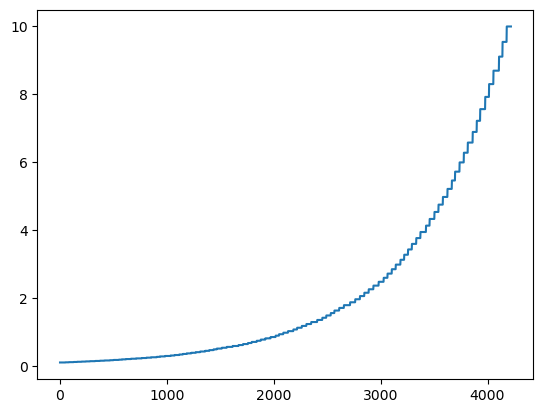

In [6]:
dataloader = DataLoader(trainsubset, batch_size=5000, shuffle=False)
schedule = ScheduleLogLinear(N=100, sigma_min=0.1, sigma_max=10)
data = next(iter(dataloader))
data = data[:,:1000]
_, sigma, eps, _= generate_train_sample(data, schedule)

plt.plot(sorted(list(sigma.flatten().numpy())))
plt.show()

torch.Size([128, 128])


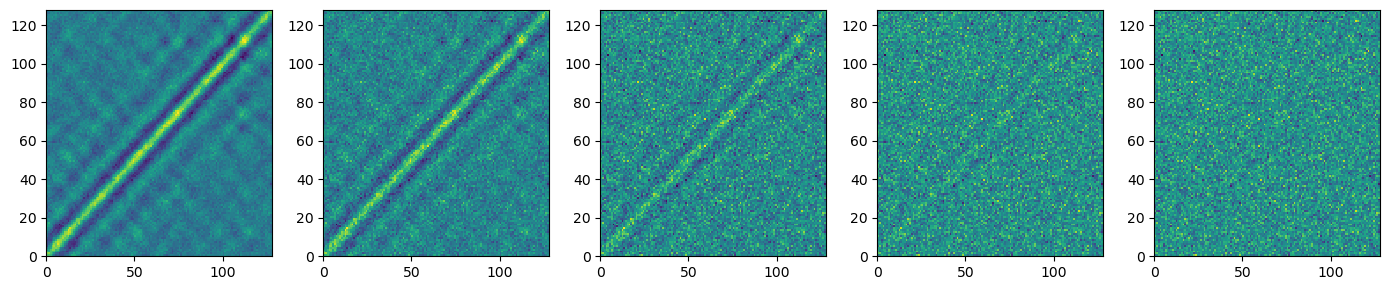

In [7]:
data = next(iter(dataloader))
data = data[:,:1000]
data = data.unsqueeze(0).unsqueeze(0)
data_resized = F.interpolate(data, size=(128, 128), mode='area') 
data_resized = data_resized.squeeze(0).squeeze(0)
data_covar = data_resized.T@data_resized

N=100
schedule = ScheduleLogLinear(N=N, sigma_min=0.1, sigma_max=10)
_, sigma, eps, _= generate_train_sample(data_covar, schedule)
noise_intsity = torch.logspace(math.log10(0.1), math.log10(10),N)

print(eps.shape)
stepsize = int(N/5)
c=1
plt.figure(figsize=(14,3))
for i in range(1,N,stepsize):
    plt.subplot(1,5,c)
    #val = torch.sqrt(sigma.unsqueeze(1)[50//i]) * data_temp + torch.sqrt(1 - sigma.unsqueeze(1)[50//i]) * eps
    val = data_covar + noise_intsity[i] * eps
    #val = data_temp * sigma.unsqueeze(1)[i] + (1 - sigma.unsqueeze(1)[i]) * eps
    plt.pcolormesh(val.numpy())
    c+=1

plt.tight_layout()
plt.show()


In [10]:
import wandb

wandb.login()

project="seis-noise-diff-covar-learn-unet-main"


# track hyperparameters and run metadata
config = dict(
    learning_rate= 5e-4,
    architecture= "Diffusion",
    dataset= "ANMO",
    batch_size=1,
    epochs= 15000,
    N=100,
    sigma_min=0.1,
    sigma_max=10)


wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: sayankrswar (sayankrswar-university-of-rochester). Use `wandb login --relogin` to force relogin


In [55]:
torch.cuda.empty_cache()

with wandb.init(project=project,config=config):
    dataloader = DataLoader(trainsubset, batch_size=5000, shuffle=False)

    model = Scaled(Unet)(in_dim=128, in_ch=1, out_ch=1, ch_mult=(2, 4, 8), ch=32, attn_resolutions=(14,), num_res_blocks = 2).to("cuda")
    schedule = ScheduleLogLinear(N=100, sigma_min=0.1, sigma_max=10)

    ema = EMA(model.parameters(), decay=0.999)
    losslist= [] 


    for ns in training_loop(dataloader, model.to("cuda"), schedule, epochs=15000, lr=5e-4):
        ns.pbar.set_description(f'Epoch {ns.epoch} | Loss={ns.loss.item():.5}')
        losslist.append(ns.loss.item())
        ema.update()
    
#trainer  = training_loop(dataloader, model.to("cuda"), schedule, epochs=1500, lr=2e-4)



Epoch 14999 | Loss=0.00093994: 100%|████████████████████████████████████████████████████████████████| 15000/15000 [38:57<00:00,  6.42it/s]


epoch,▁▁▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇██
loss,▆▄▂▂▄▂▁▁▁▁█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,14999
loss,0.00094


# Type I Sampling with one signal average

In [85]:
model.eval()
with ema.average_parameters():
    *xts, x0 = samples(model.to("cuda"), 
                        schedule.sample_sigmas(50),
                        gam=torch.tensor([2]).to("cuda"))
print(x0.shape)

torch.Size([1, 1, 128, 128])


In [86]:
print(x0.shape)
results_x0 = x0.squeeze(0).squeeze(0).cpu().numpy()
results_x0.shape

torch.Size([1, 1, 128, 128])


(128, 128)

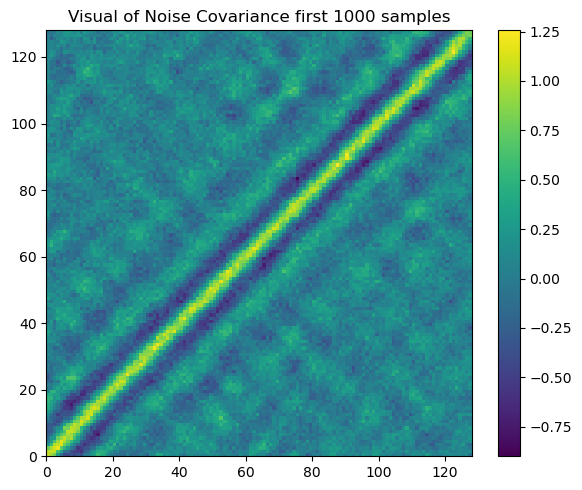

In [87]:
plt.figure(1, figsize=(6, 5))

plt.subplot(1, 1, 1)
plt.title('Visual of Noise Covariance first 1000 samples')
plt.pcolormesh(results_x0)
plt.colorbar()

plt.tight_layout()
plt.show()

torch.Size([1, 1, 128, 128])
torch.Size([1000, 1000])


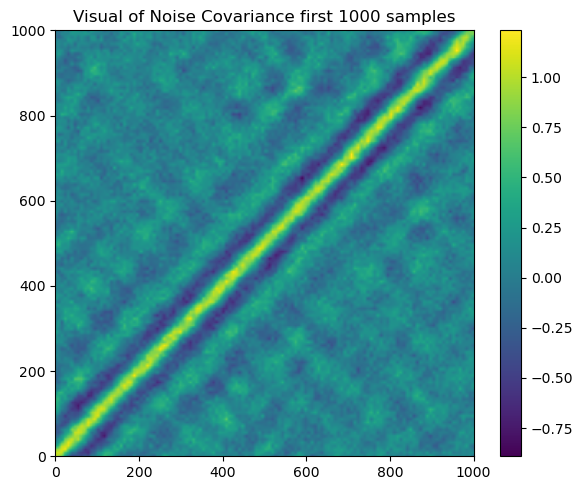

In [88]:
data_resized = x0
print(data_resized.shape)
data_upsampled = F.interpolate(data_resized, size=(1000, 1000), mode='bilinear', align_corners=True)
data_upsampled = data_upsampled.squeeze(0).squeeze(0)  # Remove batch and channel dims
print(data_upsampled.shape)


plt.figure(1, figsize=(6, 5))
plt.subplot(1, 1, 1)
plt.title('Visual of Noise Covariance first 1000 samples')
plt.pcolormesh(data_upsampled.cpu().numpy())
plt.colorbar()

plt.tight_layout()
plt.show()

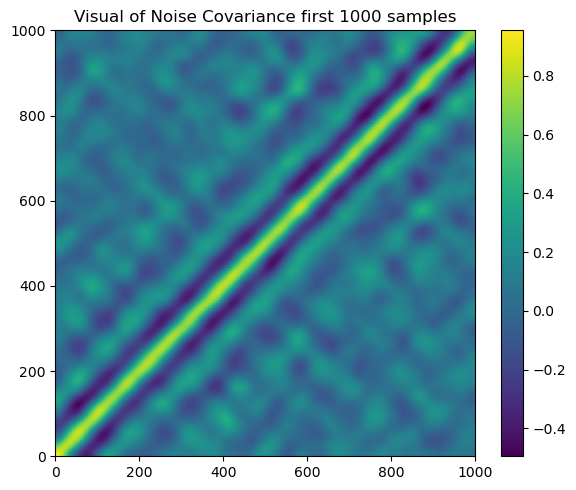

In [89]:
from torchvision.transforms import GaussianBlur

smoothing_kernel_size = 49  # Define kernel size for smoothing
data_smoothed = GaussianBlur(kernel_size=smoothing_kernel_size, sigma=(11, 19))(data_upsampled.unsqueeze(0).unsqueeze(0))
data_smoothed = data_smoothed.squeeze(0).squeeze(0)  # Remove batch and channel dims

plt.figure(1, figsize=(6, 5))

plt.subplot(1, 1, 1)
plt.title('Visual of Noise Covariance first 1000 samples')
plt.pcolormesh(data_smoothed.cpu().numpy())
plt.colorbar()

plt.tight_layout()
plt.show()

## Histogram Comparison

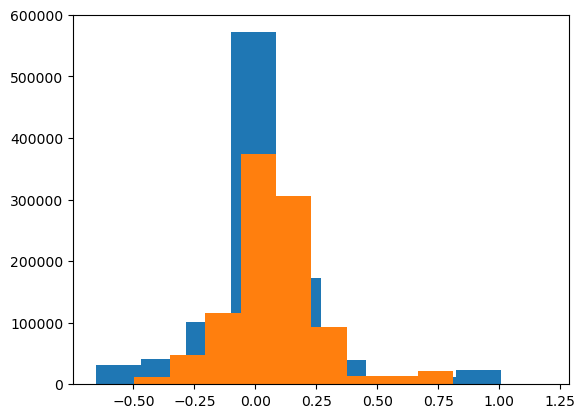

In [ ]:
data = next(iter(dataloader))
data = data[:,:1000]
data = data.T@data
for i in range(0,len(data)):
                data[i] = data[i]/data[i,i]

plt.hist(data.flatten().numpy())
plt.hist(data_smoothed.cpu().numpy().flatten())
#plt.savefig("PRJ_AUTO_NOISEPARAM/results/results_model_v1.png")
plt.show()